# Exploring YAMNet predictions On SONYC audio files
This notebook examines the initial set of YAMNet predictions from 1 month of data (Feb - Mar) from each of the 4 years.

In [1]:
import sys
import h5py
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import compress 

sys.path.append('../')
from envir import config

#### Define Functions
1) format date object
2) process the files
3) to plot by year

In [2]:
def date_formatter(time):
    return datetime.datetime.fromtimestamp(float(time.split('_')[1])).strftime('%Y-%m-%d %H:%M:%S')

In [3]:
thres = 0.5
def process_file(file):
    sensor2 = h5py.File(config.dataFol+'YAMNet/dense-bird/'+file,'r')

    pred_timestamps2 = []
    pred_avgs2 = []

    #Filter all valid predictions by timestamp and take the average
    for time in list(sensor2.keys()):
        #timestamp = date_formatter(time)
        timestamp = time.split('_')[1] #=> keep the epoch time format
        filter_list = list(filter(lambda x: (x >= thres) , np.array(sensor2[time]))) 
        if len(filter_list) > 0:
            pred_timestamps2.append(timestamp)
            pred_avgs2.append(np.mean(filter_list))
    
    # Convert the dictionary to a DataFrame
    sensor2_df=pd.DataFrame(data={'datetime': pred_timestamps2})

    #convert epoch time to datetime
    sensor2_df['datetime'] = pd.to_datetime(sensor2_df['datetime'].values.astype(np.float64), unit='s')  
    #convert utc datetime to est datetime
    sensor2_df['datetime'] = sensor2_df['datetime'].dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
    #convert est datetime to formatted string
    sensor2_df['datetime'] = sensor2_df['datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')

    #split datetime into smaller time ranges
    sensor2_df['year_month_day'] = [x.split(' ')[0] for x in sensor2_df['datetime'] ]
    #sensor2_df['month_day'] = [x.split(' ')[0][5:] for x in sensor2_df['datetime'] ]
    sensor2_df['time'] = [x.split(' ')[1] for x in sensor2_df['datetime'] ]
    sensor2_df['hour'] = [(x.split(' ')[1]).split(':')[0] for x in sensor2_df['datetime'] ]
    sensor2_df['hour_min'] = [x.split(' ')[1][:5] for x in sensor2_df['datetime'] ]

    #add average predication value
    sensor2_df['average_pred'] = pred_avgs2
    sensor2_df.head()
    return sensor2_df

In [4]:
#define a function to plot the count of avg predictions by year 
def plot_by_year(yr, df, sensor):
    ind = [True if x.split('-')[0] == str(yr) else False for x in df['year_month_day']]
    df_cnt = df[ind].groupby('year_month_day')['average_pred'].count().reset_index()
    df_cnt.rename(columns = {'year_month_day':'Day','average_pred': 'Count of Positive Predictions'}, inplace = True)
    df_cnt.plot(x='Day', 
                y='Count of Positive Predictions',
                figsize=(8,5),
                title='Year: '+str(year)+' Sensor: '+sensor,
                legend = True)

In [5]:
import matplotlib.dates as mdates

def plot_by_year2(years):    
    # create a color palette
    palette = plt.get_cmap('Set1')
    fig, axs = plt.subplots(2,2, figsize=(20,10), sharey = True)
    fig.autofmt_xdate()
    num = 0
    i = 0
    for i in [0,1]:
        year = years[num]
        for j in [0,1]:
                year = years[num]
                num += 1
                ind = [True if x.split('-')[0] == str(year) else False for x in sensor2_df['year_month_day']]
                sensor2_df_cnt = sensor2_df[ind].groupby('year_month_day')['average_pred'].count().reset_index()
                sensor2_df_cnt['month_day'] = [x.split(' ')[0][5:] for x in sensor2_df_cnt['year_month_day'] ]
                sensor2_df_cnt.rename(columns = {'month_day':'Day',
                                                 'average_pred': 'Count of Positive Predictions'},
                                      inplace = True)
        
                axs[i][j].plot(sensor2_df_cnt['Day'], sensor2_df_cnt['Count of Positive Predictions'], marker='',\
                         color=palette(num), 
                               linewidth=2,
                               alpha=0.9, 
                               label='Count of Positive Predictions in '+str(year))
                axs[i][j].legend()
            
                axs[i][j].fmt_xdata = mdates.DateFormatter('%m-%d')
                for tick in axs[i][j].get_xticklabels():
                    tick.set_rotation(90)

In [6]:
def plot_by_day(possible_peak_days, df, sensor):
    for day in possible_peak_days:
        try:
            plt = df[df['year_month_day'] == day].plot(x='time',y='average_pred',
                figsize=(10,5),title='Sensor: '+sensor+' Day: '+day,legend = True)
            #df.plot(x='A', y='B')
        except:
            print('Day: '+day+' has no numeric data to plot')

In [7]:
def agg_df(year, sensor_df):
    ind = [True if x.split('-')[0] == str(year) else False for x in sensor_df['year_month_day']]
    sensor_df_temp = sensor_df[ind].groupby('year_month_day')['average_pred'].count().reset_index()
    sensor_df_temp['month_day'] = [x.split(' ')[0][5:] for x in sensor_df_temp['year_month_day'] ]
    sensor_df_temp.rename(columns = {'month_day':'Day',
                                     'average_pred': 'Count of Positive Predictions'},
                          inplace = True)
    sensor_df_temp.sort_values(by='Day')
    return sensor_df_temp

def agg_count(years, sensor_df):
    sensor_df_2017 = agg_df(2017,sensor_df)
    sensor_df_2018 = agg_df(2018,sensor_df)
    sensor_df_2019 = agg_df(2019,sensor_df)
    sensor_df_2020 = agg_df(2020,sensor_df)

    sensor_df_cnt_2017 = pd.DataFrame({'Day':sensor_df_2017['Day'],
                                       'Count_of_Pred':sensor_df_2017['Count of Positive Predictions']})
    sensor_df_cnt_2018 = pd.DataFrame({'Day':sensor_df_2018['Day'],
                                       'Count_of_Pred':sensor_df_2018['Count of Positive Predictions']})
    sensor_df_cnt_2019 = pd.DataFrame({'Day':sensor_df_2019['Day'], 
                                       'Count_of_Pred':sensor_df_2019['Count of Positive Predictions']})
    sensor_df_cnt_2020 = pd.DataFrame({'Day':sensor_df_2020['Day'], 
                                       'Count_of_Pred':sensor_df_2020['Count of Positive Predictions']})
    
    return sensor_df_cnt_2017,sensor_df_cnt_2018,sensor_df_cnt_2019,sensor_df_cnt_2020


## Explore the dense bird data (#1 class, 5 sensors, 4 years) 

### I. Exploring possible storage data structure: sensor Kimmel Center b827eb905497

In [8]:
#read in file
sensor1 = h5py.File(config.dataFol+'YAMNet/dense-bird/b827eb905497_yamnet-pred-bird.h5','r')

In [9]:
sensor1['b827eb905497_1489588141.99']

<HDF5 dataset "b827eb905497_1489588141.99": shape (19,), type "<f4">

In [10]:
#Get all timestamps in this sensor dataset
timestamps = [date_formatter(time) for time in list(sensor1.keys())]

In [11]:
#list of valid predictions by timestamp in one dictionary: {key = timestamp, value = list(valid_prediction)}
predictions = {}

#Filter all valid predictions by timestamp
for time in list(sensor1.keys()):
    timestamp = date_formatter(time)
    filter_list = list(filter(lambda x: (x >= thres) , np.array(sensor1[time]))) 
    if len(filter_list) > 0:
        predictions[timestamp] = filter_list

In [12]:
print("First ten timestamp/prediction pairs: \n" + str(dict(list(predictions.items())[0: 10]))) 


First ten timestamp/prediction pairs: 
{'2017-03-15 11:27:17': [0.6257826], '2017-03-15 13:09:58': [0.5132104], '2017-03-15 13:10:55': [0.69220865, 0.53375506], '2017-03-15 13:16:56': [0.62291694, 0.6979787], '2017-03-15 13:44:59': [0.6883642, 0.84211606, 0.8913051, 0.9725672, 0.89986646, 0.7114761, 0.88659537, 0.7989259, 0.84907484, 0.69008064, 0.9287765, 0.7895293, 0.8406479], '2017-03-15 14:51:13': [0.54694366], '2017-03-15 14:54:07': [0.66159356, 0.5830577], '2017-03-15 14:57:10': [0.5056023, 0.5025351], '2017-03-15 15:20:36': [0.50584257, 0.8815227, 0.51817524, 0.5131744], '2017-03-15 16:28:57': [0.66559184]}


In [13]:
len(predictions.items())

6029

In [14]:
# mean_prediction by timestamp in one dictionary: {key = timestamp, value = avg(prediction)}
mean_predictions = {}

#Filter all valid predictions by timestamp and take the average
for time in list(sensor1.keys()):
    timestamp = date_formatter(time)
    filter_list = list(filter(lambda x: (x >= thres) , np.array(sensor1[time]))) 
    if len(filter_list) > 0:
        mean_predictions[timestamp] = np.mean(filter_list)

In [15]:
print("First ten timestamp/mean_prediction pairs: \n" + str(dict(list(mean_predictions.items())[0: 10]))) 


First ten timestamp/mean_prediction pairs: 
{'2017-03-15 11:27:17': 0.6257826, '2017-03-15 13:09:58': 0.5132104, '2017-03-15 13:10:55': 0.61298186, '2017-03-15 13:16:56': 0.66044784, '2017-03-15 13:44:59': 0.82994807, '2017-03-15 14:51:13': 0.54694366, '2017-03-15 14:54:07': 0.62232566, '2017-03-15 14:57:10': 0.50406873, '2017-03-15 15:20:36': 0.60467875, '2017-03-15 16:28:57': 0.66559184}


In [16]:
len(mean_predictions.items())

6029

In [17]:
#alternative way: instead of storing in one dictionary, store the key/value pairs in two lists, pred_timestamps & pred_avgs
pred_timestamps = []
pred_avgs = []

#Filter all valid predictions by timestamp and take the average
for time in list(sensor1.keys()):
    timestamp = date_formatter(time)
    filter_list = list(filter(lambda x: (x >= thres) , np.array(sensor1[time]))) 
    if len(filter_list) > 0:
        pred_timestamps.append(timestamp)
        pred_avgs.append(np.mean(filter_list))
        

In [18]:
print("First ten timestamps: \n" + str(pred_timestamps[0: 10]))
print("First ten mean_predications : \n" + str(pred_avgs[0: 10])) 


First ten timestamps: 
['2017-03-15 11:27:17', '2017-03-15 13:09:58', '2017-03-15 13:10:55', '2017-03-15 13:16:56', '2017-03-15 13:44:59', '2017-03-15 14:51:13', '2017-03-15 14:54:07', '2017-03-15 14:57:10', '2017-03-15 15:20:36', '2017-03-15 16:28:57']
First ten mean_predications : 
[0.6257826, 0.5132104, 0.61298186, 0.66044784, 0.82994807, 0.54694366, 0.62232566, 0.50406873, 0.60467875, 0.66559184]


In [19]:
len(pred_timestamps)

6029

### II. Sensor: 19 Washington Square North b827eb815321 

In [20]:
sensor2 = h5py.File(config.dataFol+'YAMNet/dense-bird/b827eb815321_yamnet-pred-bird.h5','r')#sonycnode-b827eb815321

In [21]:
pred_timestamps2 = []
pred_avgs2 = []

#Filter all valid predictions by timestamp and take the average
for time in list(sensor2.keys()):
    #timestamp = date_formatter(time)
    timestamp = time.split('_')[1] #=> keep the epoch time format
    filter_list = list(filter(lambda x: (x >= thres) , np.array(sensor2[time]))) 
    if len(filter_list) > 0:
        pred_timestamps2.append(timestamp)
        pred_avgs2.append(np.mean(filter_list))

In [22]:
len(pred_timestamps2)

7651

In [23]:
len(pred_avgs2)

7651

In [24]:
#combine two list into one dictionary:{key = pred_timestamps2, value = pred_avgs2}
mean_predictions2 = dict(zip(pred_timestamps2, pred_avgs2))

In [25]:
print("First ten timestamp/prediction pairs: \n" + str(dict(list(mean_predictions2.items())[0: 10]))) 


First ten timestamp/prediction pairs: 
{'1488108727.10': 0.69443905, '1488109080.95': 0.6635633, '1488109739.53': 0.6705529, '1488109916.66': 0.72397447, '1488109974.56': 0.6227698, '1488110040.87': 0.5579835, '1488110097.98': 0.6591636, '1488110158.59': 0.60169125, '1488110279.60': 0.6010338, '1488110341.11': 0.65501696}


In [26]:
# Convert the dictionary to a DataFrame
sensor2_df=pd.DataFrame(data={'datetime': pred_timestamps2})

#convert epoch time to datetime
sensor2_df['datetime'] = pd.to_datetime(sensor2_df['datetime'].values.astype(np.float64), unit='s')  
#convert utc datetime to est datetime
sensor2_df['datetime'] = sensor2_df['datetime'].dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
#convert est datetime to formatted string
sensor2_df['datetime'] = sensor2_df['datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')


In [27]:
sensor2_df.head()

,datetime
0,2017-02-26 06:32:07
1,2017-02-26 06:38:00
2,2017-02-26 06:48:59
3,2017-02-26 06:51:56
4,2017-02-26 06:52:54


In [28]:
#split datetime into smaller time ranges
sensor2_df['year_month_day'] = [x.split(' ')[0] for x in sensor2_df['datetime'] ]
#sensor2_df['month_day'] = [x.split(' ')[0][5:] for x in sensor2_df['datetime'] ]
sensor2_df['time'] = [x.split(' ')[1] for x in sensor2_df['datetime'] ]
sensor2_df['hour'] = [(x.split(' ')[1]).split(':')[0] for x in sensor2_df['datetime'] ]
sensor2_df['hour_min'] = [x.split(' ')[1][:5] for x in sensor2_df['datetime'] ]

#add average predication value
sensor2_df['average_pred'] = pred_avgs2


In [29]:
sensor2_df.head()

,datetime,year_month_day,time,hour,hour_min,average_pred
0,2017-02-26 06:32:07,2017-02-26,06:32:07,06,06:32,0.694439
1,2017-02-26 06:38:00,2017-02-26,06:38:00,06,06:38,0.663563
2,2017-02-26 06:48:59,2017-02-26,06:48:59,06,06:48,0.670553
3,2017-02-26 06:51:56,2017-02-26,06:51:56,06,06:51,0.723974
4,2017-02-26 06:52:54,2017-02-26,06:52:54,06,06:52,0.622770


#### Some line plots:

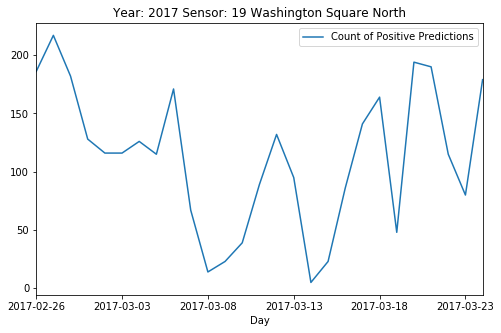

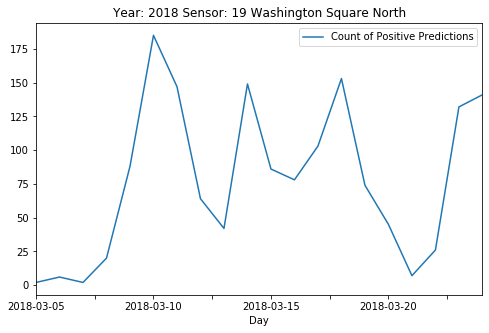

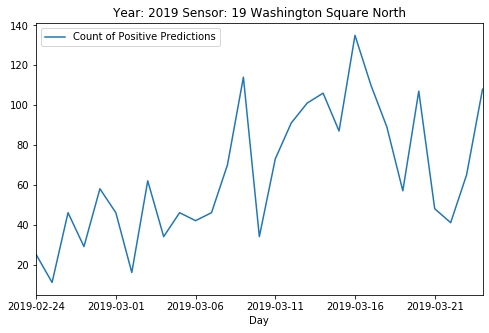

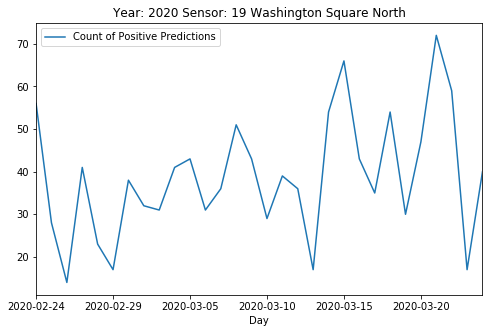

In [30]:
for year in [2017,2018,2019,2020]:
    plot_by_year(yr=year, df=sensor2_df, sensor = '19 Washington Square North')

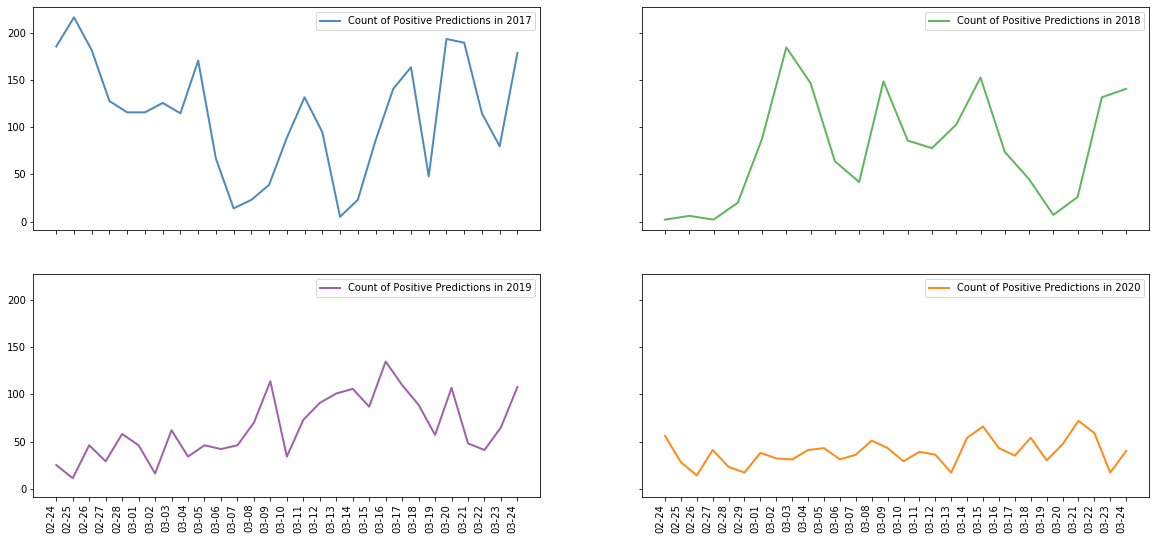

In [31]:
plot_by_year2([2017,2018,2019,2020])

In [32]:
sensor2_df.head()

,datetime,year_month_day,time,hour,hour_min,average_pred
0,2017-02-26 06:32:07,2017-02-26,06:32:07,06,06:32,0.694439
1,2017-02-26 06:38:00,2017-02-26,06:38:00,06,06:38,0.663563
2,2017-02-26 06:48:59,2017-02-26,06:48:59,06,06:48,0.670553
3,2017-02-26 06:51:56,2017-02-26,06:51:56,06,06:51,0.723974
4,2017-02-26 06:52:54,2017-02-26,06:52:54,06,06:52,0.622770


In [33]:
sensor2_df_cnt1, sensor2_df_cnt2,sensor2_df_cnt3, sensor2_df_cnt4= agg_count([2017,2018,2019,2020], sensor2_df)

In [34]:
sensor2_df_cnt1.head()

,Day,Count_of_Pred
0,02-26,186
1,02-27,217
2,02-28,182
3,03-01,128
4,03-02,116


In [35]:
sensor2_df_cnt2.head()

,Day,Count_of_Pred
0,03-05,2
1,03-06,6
2,03-07,2
3,03-08,20
4,03-09,88


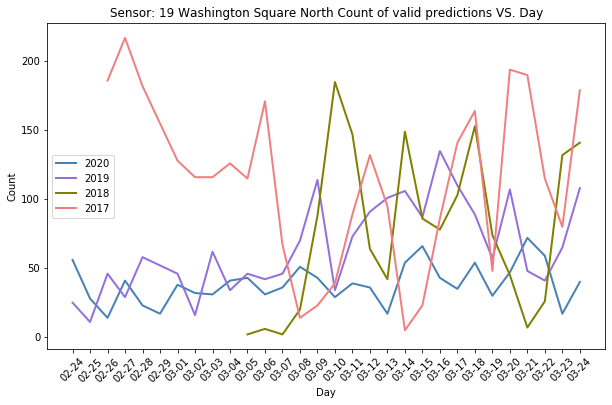

In [36]:
# multiple line plot
plt.figure(figsize=(10,6))
plt.plot( 'Day', 'Count_of_Pred', data=sensor2_df_cnt4, marker='', color='steelblue', linewidth=2, label="2020")
plt.plot( 'Day', 'Count_of_Pred', data=sensor2_df_cnt3, marker='', color='mediumpurple', linewidth=2, label="2019")
plt.plot( 'Day', 'Count_of_Pred', data=sensor2_df_cnt2, marker='', color='olive', linewidth=2, label="2018")
plt.plot( 'Day', 'Count_of_Pred', data=sensor2_df_cnt1, marker='', color='lightcoral', linewidth=2,label="2017")

plt.xticks(rotation=45)
plt.xlabel('Day')
plt.ylabel('Count')
plt.title('Sensor: 19 Washington Square North Count of valid predictions VS. Day')
plt.legend()


#### Visualize by Hour

Text(0, 0.5, 'Count')

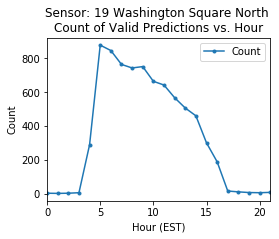

In [37]:
# count(average_pred) vs. Hour
hour_cnt2 = sensor2_df.groupby('hour')['average_pred'].count().reset_index()
hour_cnt2.rename(columns = {'hour': 'Hour', 'average_pred': 'Count'}, inplace = True)
ax2 = hour_cnt2.plot(figsize=(4,3), marker='.',
                     title ='Sensor: 19 Washington Square North \nCount of Valid Predictions vs. Hour')
ax2.set_xlabel("Hour (EST)")
ax2.set_ylabel("Count")

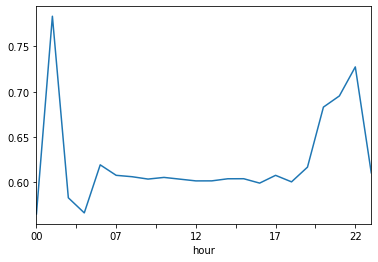

In [38]:
# mean(average_pred) vs. Hour
sensor2_df.groupby('hour')['average_pred'].mean().plot()   #---> does not help much


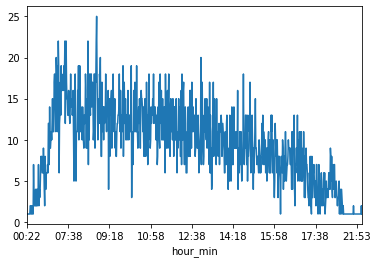

In [39]:
# count(average_pred) vs. hour_min
plt = sensor2_df.groupby('hour_min')['average_pred'].count().plot()

#### Potential Peaks Observed from kokx radar scan （annual mtr by month)
Feb.
- 2/9/2017
- 2/2/2018, 2/5/2018, 2/7/2018, 2/18/2018
- 2/21/2019

March
- 3/10/2017
- 3/2/2018, 3/8/2018, 3/22/2018
- 3/4/2019, 3/16/2019

Day: 2018-02-24 has no numeric data to plot
Day: 2018-02-26 has no numeric data to plot
Day: 2019-02-29 has no numeric data to plot


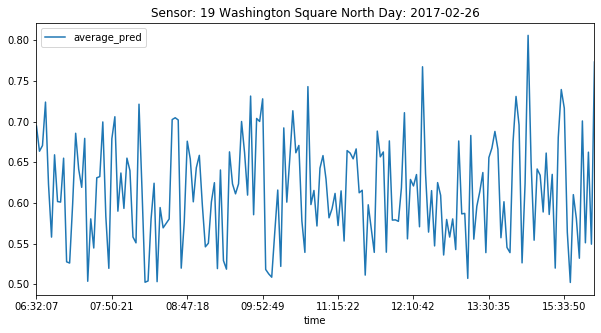

In [40]:
#For Feburary
possible_peak_days = ['2017-02-26','2018-02-24','2018-02-26','2019-02-29']
#sensor2_0226 = sensor2_df[sensor2_df['day'] == '2017-02-26']
plot_by_day(possible_peak_days,df=sensor2_df, sensor='19 Washington Square North')

In [41]:
sensor2_df[sensor2_df['year_month_day'] == '2017-02-26'].head()

,datetime,year_month_day,time,hour,hour_min,average_pred
0,2017-02-26 06:32:07,2017-02-26,06:32:07,06,06:32,0.694439
1,2017-02-26 06:38:00,2017-02-26,06:38:00,06,06:38,0.663563
2,2017-02-26 06:48:59,2017-02-26,06:48:59,06,06:48,0.670553
3,2017-02-26 06:51:56,2017-02-26,06:51:56,06,06:51,0.723974
4,2017-02-26 06:52:54,2017-02-26,06:52:54,06,06:52,0.622770


In [42]:
#2018-02-26: shows no predication values above the threshold
sensor2_df[sensor2_df['year_month_day'] == '2018-02-26']

,datetime,year_month_day,time,hour,hour_min,average_pred


Day: 2018-03-02 has no numeric data to plot


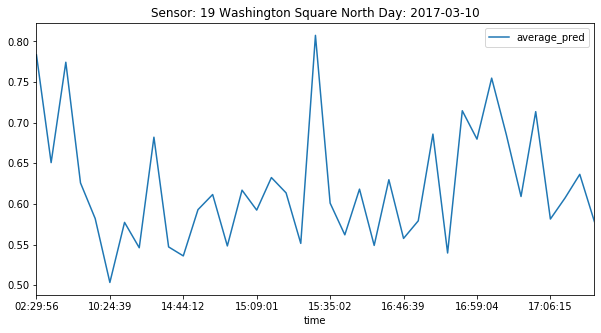

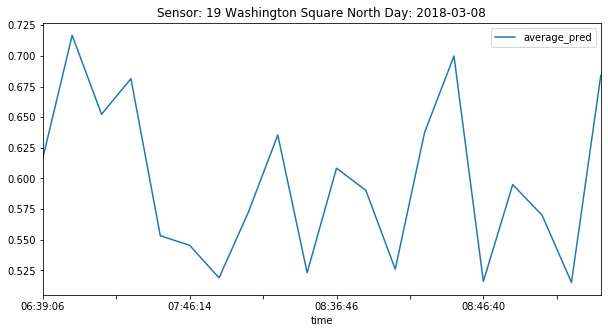

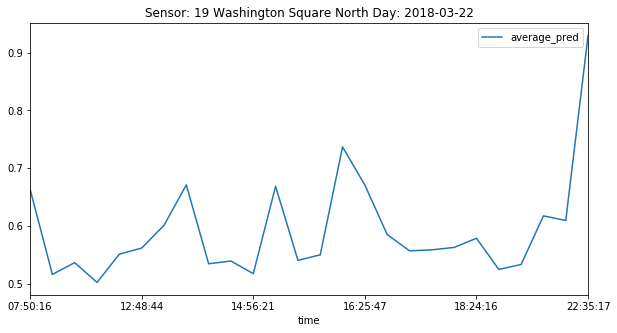

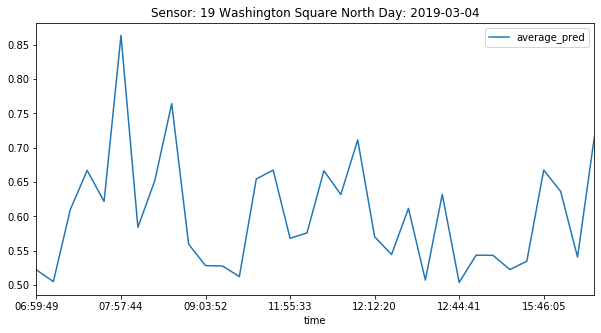

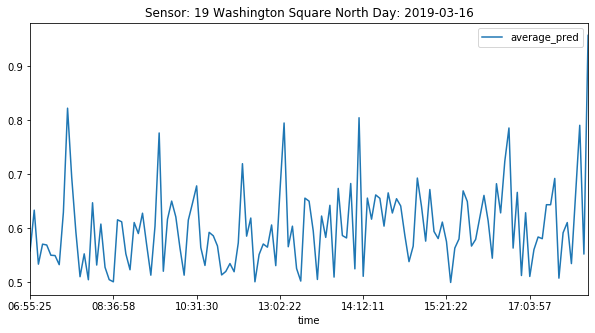

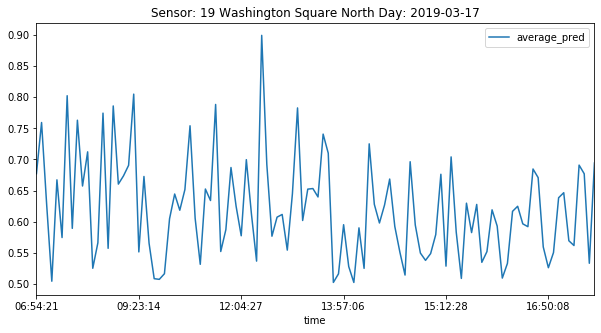

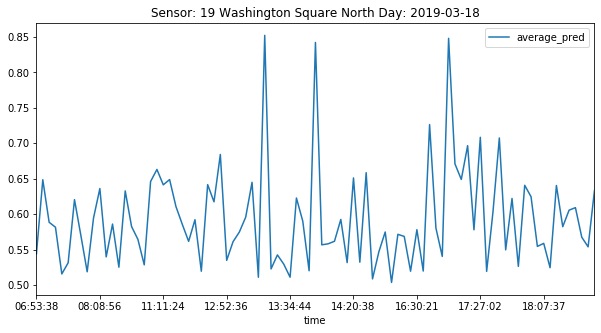

In [43]:
#For March
possible_peak_days = ['2017-03-10','2018-03-02','2018-03-08','2018-03-22','2019-03-04',\
                      '2019-03-16','2019-03-17','2019-03-18']
plot_by_day(possible_peak_days, df = sensor2_df, sensor='19 Washington Square North')

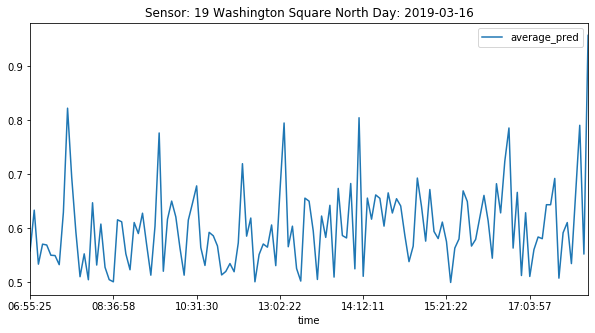

In [44]:
sensor2_df[sensor2_df['year_month_day'] == '2019-03-16'].plot(x='time',y='average_pred',\
                        figsize=(10,5),title='Sensor: 19 Washington Square North Day: 2019-03-16',legend = True)


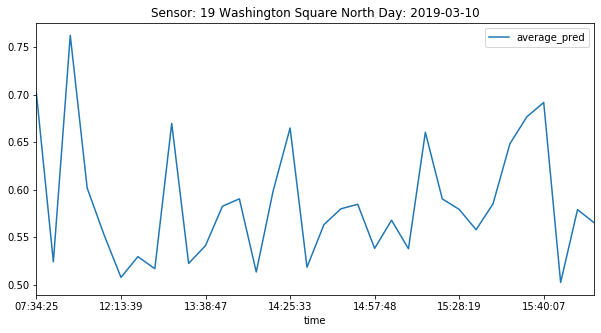

In [45]:
sensor2_df[sensor2_df['year_month_day'] == '2019-03-10'].plot(x='time',y='average_pred',\
                        figsize=(10,5),title='Sensor: 19 Washington Square North Day: 2019-03-10',legend = True)


In [46]:
sensor2_df[sensor2_df['year_month_day'] == '2019-03-16'].shape

(135, 6)

In [47]:
sensor2_df[sensor2_df['year_month_day'] == '2019-03-10'].shape

(34, 6)

### III Sensor 4 Washington Square North b827eb8e2420

In [48]:
from os import listdir
from os.path import isfile, join

#Add all files under 'YAMNet/dense-bird' to a list
#yamNetFiles = [f for f in listdir(config.dataFol+'YAMNet/dense-bird') if isfile(join(config.dataFol+'YAMNet/dense-bird', f))]


In [49]:
yamNetFiles = ['b827eb8e2420_yamnet-pred-bird.h5','b827eb905497_yamnet-pred-bird.h5', 'b827eb0fedda_yamnet-pred-bird.h5',
 'b827eb1685c7_yamnet-pred-bird.h5']


In [50]:
sensor3_df = process_file('b827eb8e2420_yamnet-pred-bird.h5')

In [51]:
sensor3_df.head()

,datetime,year_month_day,time,hour,hour_min,average_pred
0,2017-03-13 19:30:29,2017-03-13,19:30:29,19,19:30,0.556343
1,2017-03-14 07:20:18,2017-03-14,07:20:18,07,07:20,0.607350
2,2017-03-14 07:22:18,2017-03-14,07:22:18,07,07:22,0.952605
3,2017-03-14 12:41:04,2017-03-14,12:41:04,12,12:41,0.578531
4,2017-03-14 12:50:51,2017-03-14,12:50:51,12,12:50,0.535372


In [52]:
sensor3_df_cnt1, sensor3_df_cnt2,sensor3_df_cnt3, sensor3_df_cnt4= agg_count([2017,2018,2019,2020], sensor3_df)
sensor3_df_cnt1['year'] = 2017
sensor3_df_cnt2['year'] = 2018
sensor3_df_cnt3['year'] = 2019
sensor3_df_cnt4['year'] = 2020

In [53]:
sensor3_df_cnt = pd.concat([sensor3_df_cnt1, sensor3_df_cnt2,sensor3_df_cnt3, sensor3_df_cnt4])
sensor3_df_cnt.head()

,Day,Count_of_Pred,year
0,03-13,1,2017
1,03-14,29,2017
2,03-15,39,2017
3,03-16,67,2017
4,03-17,76,2017


In [54]:
import seaborn as sns

/home/cusp/xy1443/.conda/envs/birdsVE3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


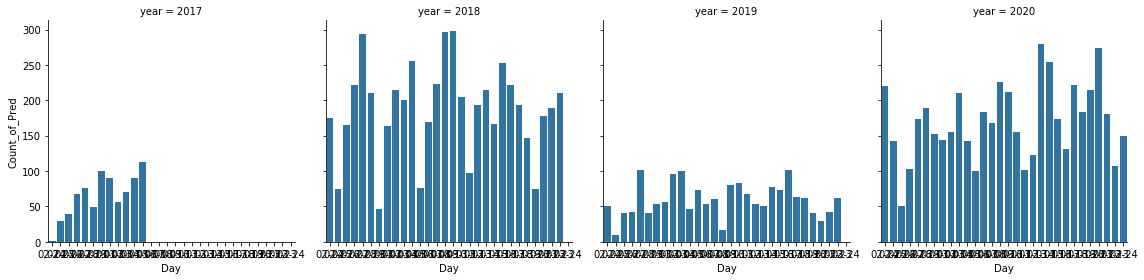

In [55]:
g = sns.FacetGrid(sensor3_df_cnt, col="year", height=4)
g.map(sns.barplot, "Day", "Count_of_Pred");

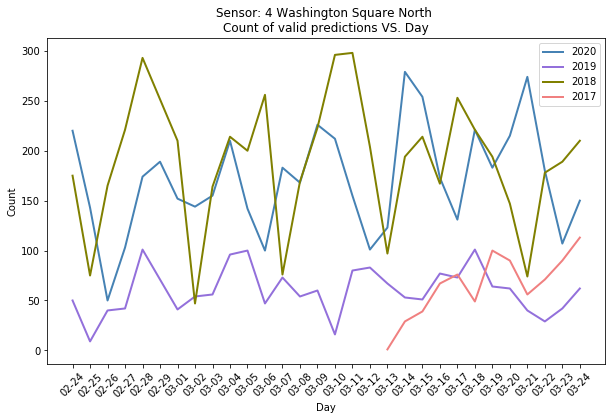

In [56]:
import matplotlib.pyplot as plt
# multiple line plot
plt.figure(figsize=(10,6))
plt.plot( 'Day', 'Count_of_Pred', data=sensor3_df_cnt4, marker='', color='steelblue', linewidth=2, label="2020")
plt.plot( 'Day', 'Count_of_Pred', data=sensor3_df_cnt3, marker='', color='mediumpurple', linewidth=2, label="2019")
plt.plot( 'Day', 'Count_of_Pred', data=sensor3_df_cnt2, marker='', color='olive', linewidth=2, label="2018")
plt.plot( 'Day', 'Count_of_Pred', data=sensor3_df_cnt1, marker='', color='lightcoral', linewidth=2,label="2017")

plt.xticks(rotation=45)
plt.xlabel('Day')
plt.ylabel('Count')
plt.title('Sensor: 4 Washington Square North \nCount of valid predictions VS. Day')
plt.legend()


Text(0, 0.5, 'Count')

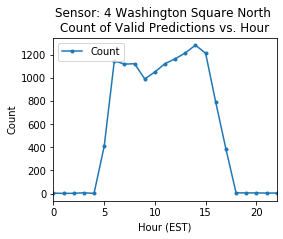

In [57]:
# count(average_pred) vs. Hour
hour_cnt3 = sensor3_df.groupby('hour')['average_pred'].count().reset_index()
hour_cnt3.rename(columns = {'hour': 'Hour', 'average_pred': 'Count'}, inplace = True)
ax3 = hour_cnt3.plot(figsize=(4,3), marker='.',
                     title ='Sensor: 4 Washington Square North \nCount of Valid Predictions vs. Hour')
ax3.set_xlabel("Hour (EST)")
ax3.set_ylabel("Count")

### IV Sensor Kimmel Center b827eb905497

In [58]:
sensor4_df = process_file('b827eb905497_yamnet-pred-bird.h5')

In [59]:
sensor4_df.head()

,datetime,year_month_day,time,hour,hour_min,average_pred
0,2017-03-15 11:27:17,2017-03-15,11:27:17,11,11:27,0.625783
1,2017-03-15 13:09:58,2017-03-15,13:09:58,13,13:09,0.513210
2,2017-03-15 13:10:55,2017-03-15,13:10:55,13,13:10,0.612982
3,2017-03-15 13:16:56,2017-03-15,13:16:56,13,13:16,0.660448
4,2017-03-15 13:44:59,2017-03-15,13:44:59,13,13:44,0.829948


In [60]:
sensor4_df_cnt1, sensor4_df_cnt2,sensor4_df_cnt3, sensor4_df_cnt4= agg_count([2017,2018,2019,2020], sensor4_df)

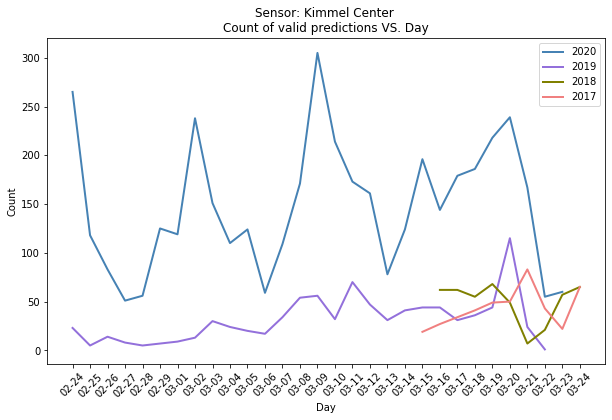

In [61]:
# multiple line plot
plt.figure(figsize=(10,6))
plt.plot( 'Day', 'Count_of_Pred', data=sensor4_df_cnt4, marker='', color='steelblue', linewidth=2, label="2020")
plt.plot( 'Day', 'Count_of_Pred', data=sensor4_df_cnt3, marker='', color='mediumpurple', linewidth=2, label="2019")
plt.plot( 'Day', 'Count_of_Pred', data=sensor4_df_cnt2, marker='', color='olive', linewidth=2, label="2018")
plt.plot( 'Day', 'Count_of_Pred', data=sensor4_df_cnt1, marker='', color='lightcoral', linewidth=2,label="2017")

plt.xticks(rotation=45)
plt.xlabel('Day')
plt.ylabel('Count')
plt.title('Sensor: Kimmel Center \nCount of valid predictions VS. Day')
plt.legend()


Text(0, 0.5, 'Count')

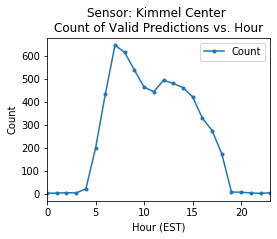

In [62]:
# count(average_pred) vs. Hour
hour_cnt4 = sensor4_df.groupby('hour')['average_pred'].count().reset_index()
hour_cnt4.rename(columns = {'hour': 'Hour', 'average_pred': 'Count'}, inplace = True)
ax4 = hour_cnt4.plot(figsize=(4,3),marker='.',
                     title ='Sensor: Kimmel Center \nCount of Valid Predictions vs. Hour')
ax4.set_xlabel("Hour (EST)")
ax4.set_ylabel("Count")

### V Sensor Juan Carlos b827eb0fedda

In [63]:
sensor5_df = process_file('b827eb0fedda_yamnet-pred-bird.h5')

In [64]:
sensor5_df.head()

,datetime,year_month_day,time,hour,hour_min,average_pred
0,2017-02-24 15:40:31,2017-02-24,15:40:31,15,15:40,0.528898
1,2017-02-24 16:29:51,2017-02-24,16:29:51,16,16:29,0.551928
2,2017-02-24 16:30:51,2017-02-24,16:30:51,16,16:30,0.651554
3,2017-02-24 16:31:50,2017-02-24,16:31:50,16,16:31,0.573084
4,2017-02-24 16:32:52,2017-02-24,16:32:52,16,16:32,0.522751


In [65]:
sensor5_df_cnt1, sensor5_df_cnt2,sensor5_df_cnt3, sensor5_df_cnt4= agg_count([2017,2018,2019,2020], sensor5_df)

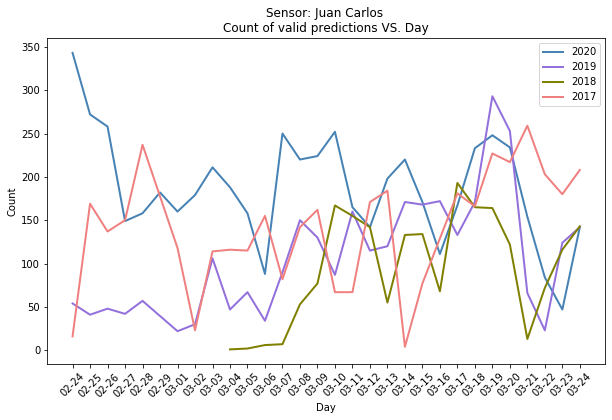

In [66]:
# multiple line plot
plt.figure(figsize=(10,6))
plt.plot( 'Day', 'Count_of_Pred', data=sensor5_df_cnt4, marker='', color='steelblue', linewidth=2, label="2020")
plt.plot( 'Day', 'Count_of_Pred', data=sensor5_df_cnt3, marker='', color='mediumpurple', linewidth=2, label="2019")
plt.plot( 'Day', 'Count_of_Pred', data=sensor5_df_cnt2, marker='', color='olive', linewidth=2, label="2018")
plt.plot( 'Day', 'Count_of_Pred', data=sensor5_df_cnt1, marker='', color='lightcoral', linewidth=2,label="2017")

plt.xticks(rotation=45)
plt.xlabel('Day')
plt.ylabel('Count')
plt.title('Sensor: Juan Carlos \nCount of valid predictions VS. Day')
plt.legend()


Text(0, 0.5, 'Count')

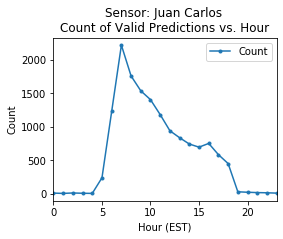

In [67]:
# count(average_pred) vs. Hour
hour_cnt5 = sensor5_df.groupby('hour')['average_pred'].count().reset_index()
hour_cnt5.rename(columns = {'hour': 'Hour', 'average_pred': 'Count'}, inplace = True)
ax5 = hour_cnt5.plot(figsize=(4,3), marker='.',
                     title ='Sensor: Juan Carlos \nCount of Valid Predictions vs. Hour')
ax5.set_xlabel("Hour (EST)")
ax5.set_ylabel("Count")

### VI Sensor Shimkin Reading Room b827eb1685c7

In [68]:
sensor6_df = process_file('b827eb1685c7_yamnet-pred-bird.h5')

In [69]:
sensor6_df.head()

,datetime,year_month_day,time,hour,hour_min,average_pred
0,2017-02-24 05:31:14,2017-02-24,05:31:14,05,05:31,0.575413
1,2017-02-24 05:38:06,2017-02-24,05:38:06,05,05:38,0.541689
2,2017-02-24 05:41:02,2017-02-24,05:41:02,05,05:41,0.526690
3,2017-02-24 05:47:16,2017-02-24,05:47:16,05,05:47,0.500499
4,2017-02-24 05:58:21,2017-02-24,05:58:21,05,05:58,0.529773


In [70]:
sensor6_df_cnt1, sensor6_df_cnt2,sensor6_df_cnt3, sensor6_df_cnt4= agg_count([2017,2018,2019,2020], sensor6_df)

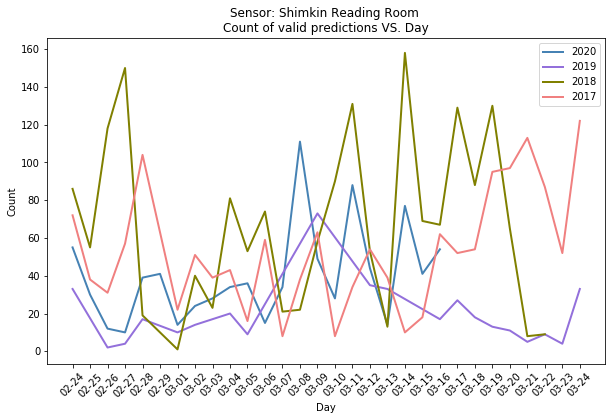

In [71]:
# multiple line plot
plt.figure(figsize=(10,6))
plt.plot( 'Day', 'Count_of_Pred', data=sensor6_df_cnt4, marker='', color='steelblue', linewidth=2, label="2020")
plt.plot( 'Day', 'Count_of_Pred', data=sensor6_df_cnt3, marker='', color='mediumpurple', linewidth=2, label="2019")
plt.plot( 'Day', 'Count_of_Pred', data=sensor6_df_cnt2, marker='', color='olive', linewidth=2, label="2018")
plt.plot( 'Day', 'Count_of_Pred', data=sensor6_df_cnt1, marker='', color='lightcoral', linewidth=2,label="2017")

plt.xticks(rotation=45)
plt.xlabel('Day')
plt.ylabel('Count')
plt.title('Sensor: Shimkin Reading Room \nCount of valid predictions VS. Day')
plt.legend()

Text(0, 0.5, 'Count')

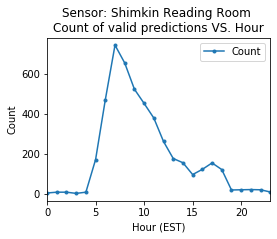

In [72]:
# count(average_pred) vs. Hour
hour_cnt6 = sensor6_df.groupby('hour')['average_pred'].count().reset_index()
hour_cnt6.rename(columns = {'hour': 'Hour', 'average_pred': 'Count'}, inplace = True)
ax6 = hour_cnt6.plot(figsize=(4,3), marker='.',
                     title ='Sensor: Shimkin Reading Room \nCount of valid predictions VS. Hour')
ax6.set_xlabel("Hour (EST)")
ax6.set_ylabel("Count")